In [1]:
from utils import FundamentalData, delta, rank, alpha_example_1, alpha_example_2, alpha_example_4, alpha_example_3, alpha_example_5, FinancialDataProcessor
from threeDF import process_data


In [5]:
def fetch_data():
    while True:
        user_input = input("To fetch data enter 1 else 0: ")
        if user_input == '1':
            process_data()
            break
        elif user_input == '0':
            print("Data fetch aborted.")
            break
        else:
            print("Invalid input. Please enter 1 or 0.")
fetch_data()

Data fetch aborted.


In [2]:
def alpha_example_6(fundamental_data):
    return {
        # 'alpha':"rank(fundamental_data.npm)",
        # 'alpha':"rank(fundamental_data.npm) + rank(fundamental_data.dte)",
        # 'alpha': "ts_rank(fundamental_data.npm, 15)",
        # 'alpha' : "adx(fundamental_data.data, 15)",
        # 'alpha' : "(fundamental_data.peRatio+fundamental_data.revenuePerShare)/ema(fundamental_data.peRatio, 50)",
        # 'alpha' : "(vwap(fundamental_data.data, 14)+1)",
        # 'alpha': "(fundamental_data.peRatio + fundamental_data.revenuePerShare) / (vwap(fundamental_data.data, 20)+1)",
        # 'alpha': "(fundamental_data.peRatio + fundamental_data.revenuePerShare) / (adx(fundamental_data.data, 14)+1)",
        'alpha': "fundamental_data.eps",
        'neutralisation': 'neutr.market',
        'decay': 5,
        'universe' : 6,
        'universe_selector' : 'fundamental_data.ebitda',
    }


       Symbol       marketCap         ebitda
0    RELIANCE  20203624468500  1786770000000
1  BHARTIARTL   9409843343758   782918000000
2         TCS  16194389935500   642960000000
3         ITC   6392811600000   262543500000
4  HINDUNILVR   6669193735500   154700000000
5        LICI   6763319933680    41336400000


/Users/khushnarang/Desktop/HFT/LFT/IFT/utils.py:371: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.weight_matrix[i, j] = alpha_values.loc[self.dates['date'][i], self.stocks['Symbol'][j]]
/Users/khushnarang/Desktop/HFT/LFT/IFT/utils.py:375: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.weight_matrix[i, j] = ((val1)*(decay_x-1) + val2) / decay_x


[[28.01  3.61 34.37  4.17 10.89 21.79]
 [28.01  3.61 34.37  4.17 10.89 21.79]
 [28.01  3.61 34.37  4.17 10.89 21.79]
 ...
 [ 9.26  1.38 13.6   0.    0.    0.  ]
 [ 9.26  1.38 13.6   0.    0.    0.  ]
 [ 9.26  1.38 13.6   0.    0.    0.  ]]


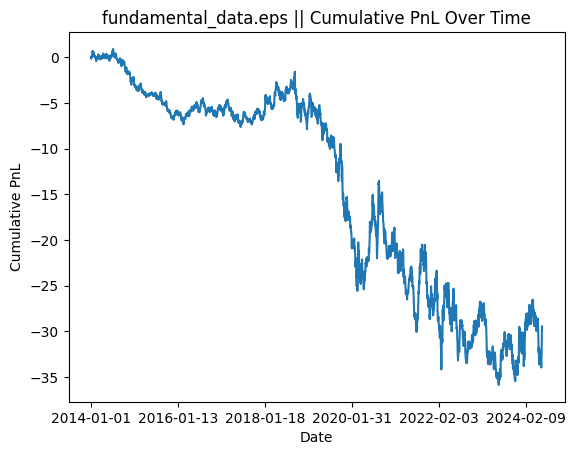

{'std_dev_daily_pnl': np.float64(0.26153044777658535),
 'sharpe_ratio': np.float64(-0.03637583876430498),
 'max_drawdown': np.float64(10.333333333333018),
 'average_daily_return': array([-0.00547797,  0.00228004, -0.00961805,  0.00145143, -0.00081658,
         0.00083135]),
 'average_turnover': np.float64(0.7095268399719101)}

In [3]:
processor = FinancialDataProcessor('date.csv', 'ind_nifty500list.csv', 'my_3d_dataarray.nc', 'sectorData.csv', alpha_example_6)
sector = input("Enter the sector['Financial Services' 'Industrials' 'Basic Materials'....etc, for all of them enter 'All' : ") 
processor.calculate_weights(sector)
processor.calculate_pnl(sector)
processor.plot_cumulative_pnl(sector)
processor.calculate_pnl_quality()